In [1]:
# Importation des bibliothèques
%matplotlib notebook
#%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from scipy import signal
from scipy.io import wavfile
import glob
import soundfile as sf
from scipy.fft import rfft, rfftfreq
import os
!pip install soundfile

In [2]:
# chemin vers signaux de la perruche à collier
dossier_collier = os.path.expanduser("ARIA/cours/signal/projet/signal/carduelis")
pattern_wav = os.path.join(dossier_collier, "*.wav")
pattern_mp3 = os.path.join(dossier_collier, "*.mp3")
fichiers1_wav = glob.glob(pattern_wav)
fichiers1_mp3 = glob.glob(pattern_mp3)

# chemin vers signaux du chardonneret élégant
dossier_carduelis = os.path.expanduser("ARIA/cours/signal/projet/signal/collier")
pattern_wav = os.path.join(dossier_carduelis, "*.wav")
pattern_mp3 = os.path.join(dossier_carduelis, "*.mp3")
fichiers2_wav = glob.glob(pattern_wav)
fichiers2_mp3 = glob.glob(pattern_mp3)

# créer un fichier avec tous les signaux mélangés
po=[]
Fs=[]
MP3=fichiers2_mp3+fichiers1_mp3
WAV=fichiers2_wav+fichiers1_wav
origine=[]
for i in MP3:
    pi, fs = sf.read(i)
    if pi.ndim == 2:  # Si le signal est stéréo (2D)
        left = pi[:, 0]  # Canal gauche
        po.append(left)
    else:  # Si le signal est mono (1D)
        po.append(pi)
    Fs.append(fs)
for i in WAV:
    fs,pi = wavfile.read(i)
    if pi.ndim == 2:  # Si le signal est stéréo (2D)
        left = pi[:, 0]  # Canal gauche
        po.append(left)
    else:  # Si le signal est mono (1D)
        po.append(pi)
    Fs.append(fs)

/var/folders/ty/tdfgymfs5x5cfpsggj0tglpr0000gn/T/ipykernel_63890/4216140487.py:30: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,pi = wavfile.read(i)


In [ ]:
npzfile = np.load('Session2.npz')
po=[]
Fs=[]

In [3]:
# algorithme de filtrage dynamique


def band_pass_filter(x,fc,Fs):
    wc=tuple(f/(Fs/2) for f in fc)
    b, a = signal.butter(4, wc, 'bandpass')
    y = signal.filtfilt(b, a, x)
    return y

def dynamic_band_pass_filter(x, Fs, threshold_ratio=0.5, margin_hz=50, exclude_below=3500, exclude_above=6000):
    """
    Automatically choose fc based on FFT peak frequencies.
    threshold_ratio: ratio (0–1) of max magnitude to define strong frequency band.
    margin_hz: frequency margin to widen the band edges.
    """
    N = len(x)
    freqs = rfftfreq(N, 1/Fs)
    fft_mag = np.abs(rfft(x))

    valid_idx = (freqs >= exclude_below) & (freqs <= exclude_above)
    freqs = freqs[valid_idx]
    fft_mag = fft_mag[valid_idx]

    threshold = threshold_ratio * np.max(fft_mag)
    strong_freqs = freqs[fft_mag > threshold]
    
    if len(strong_freqs) == 0:
        print("No strong frequencies detected. Returning original signal.")
        return x, (0, Fs/2)

    f_low = max(0, np.min(strong_freqs) - margin_hz)
    f_high = min(Fs/2, np.max(strong_freqs) + margin_hz)
    fc = (f_low, f_high)
    
    #print(f"Auto-selected band: {f_low:.1f} Hz – {f_high:.1f} Hz for {file}")
    
    y = band_pass_filter(x, fc, Fs)
    
    return y, fc

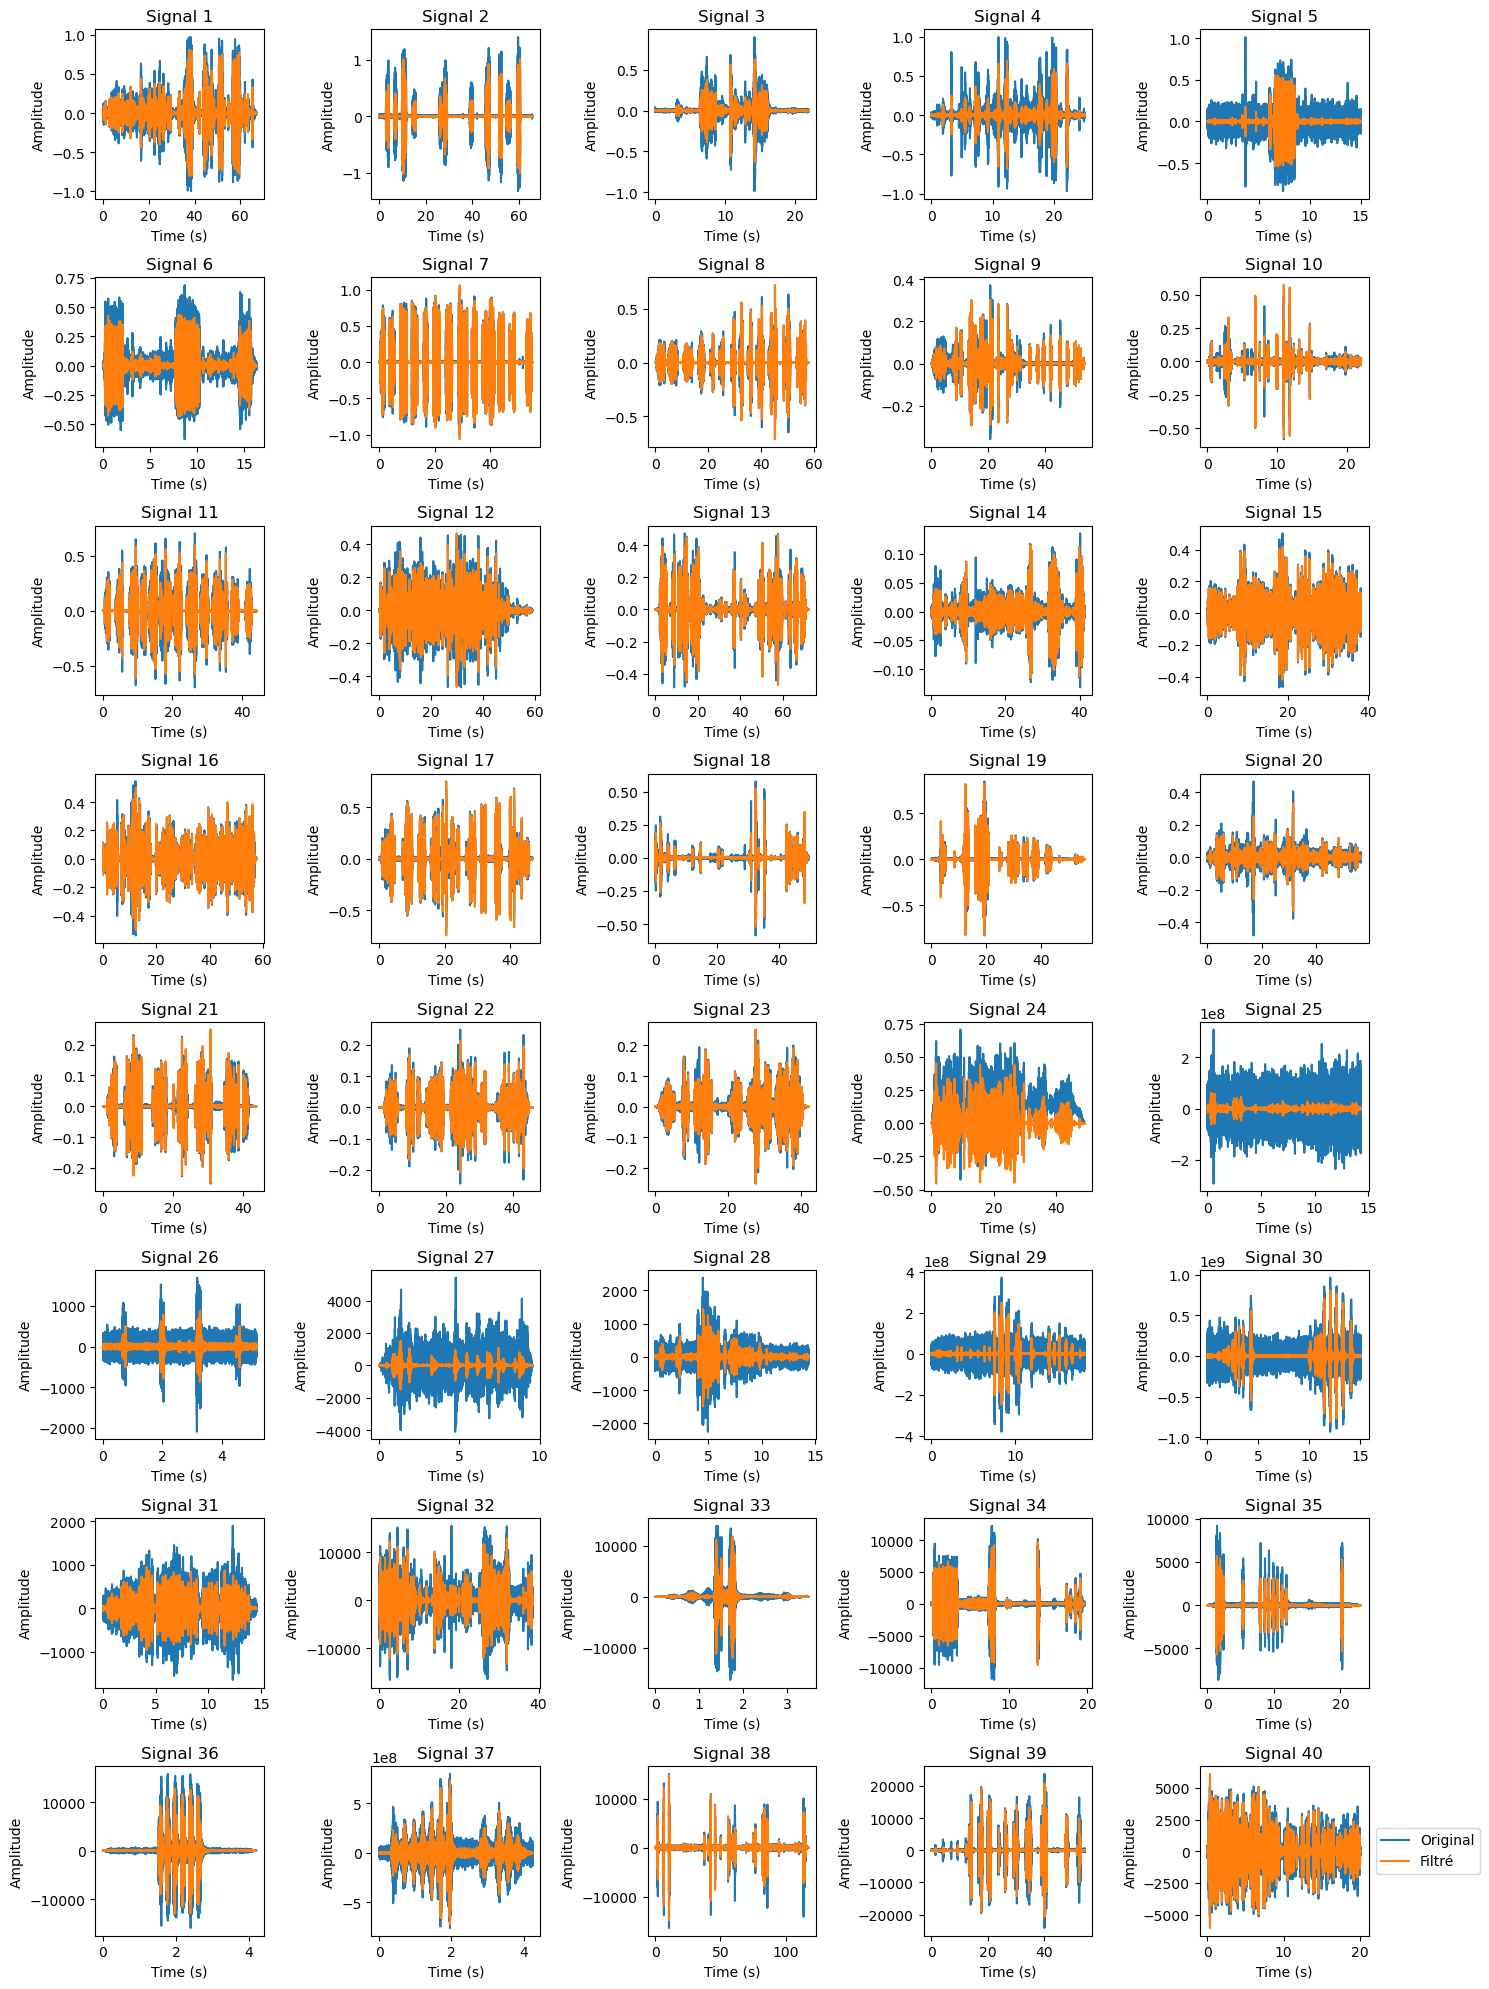

In [4]:
# Création d'une liste avec les signaux filtrés et visualisation de la filtration des signaux

plt.figure(figsize=(15, 20))
fc=(3500,6000)
filtré=[]
for i in range(len(Fs)):
    y,fc=dynamic_band_pass_filter(po[i], Fs[i], threshold_ratio=0.5, margin_hz=50, exclude_below=3500, exclude_above=6000)
    plt.subplot(8, 5, i + 1)
    N=len(po[i])
    t=np.arange(N)/Fs[i]
    plt.plot(t, po[i], label='Original')
    plt.plot(t, y, label='Filtré')
    plt.title(f'Signal {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    filtré.append(y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [5]:
# Algorithme d'extraction la partie positive du signal
def positif(F):
    Y=[]
    for n in range(len(F)):
        x=F[n]
        p=np.zeros(len(x))
        for i in range(len(x)):
            if x[i] >= 0:
                p[i]=x[i]
        Y.append(p)
    return Y

# Réalisation d'un spectrogramme

def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,Sxx

In [6]:
# Algorithme de rupture selon le signal
def fonction(Q,S,F,Fs):
    Temps=[] # 
    Sign=[]  # signal modifié
    coupe=positif(F) # signal avec que la partie positive
    Signal = [f.copy() for f in F] # copie le signal original
    clivage = [[] for _ in range(len(F))] # prend les différentes coupures
    for o in Q: # différentes longueur de temps
        for n in range(len(Fs)): # pour chaque signal
            X=coupe[n] # signal modifié  partie positive sur lequel on mesure la moyenne
            P=Signal[n] # signal modifié avec partie positive et négative
            T=int(Fs[n]*o) # longueur du temps
            m=np.zeros(len(X)//T+1) # nombre de sous signaux de longueur O
            for i in range(len(X)//T+1): # pour chaque segment
                if len(X[i*T:T*(i+1)])==0: # si rien dans le segment
                    m[i]=0
                else:
                    moy=np.mean(X[i*T:T*(i+1)])
                    m[i]=moy
            coupure=[]
            cli=[]
            seuil = np.mean(m) * S
            for l in range (len(m)):
                if m[l]>seuil:
                    coupure.append(l)
                else:
                    cli.append(l)
            X2 = [X[i*T : (i+1)*T] for i in coupure]
            Si2 = [P[i*T : (i+1)*T] for i in coupure]
            nouvelles_coupures =[(i*T, (i+1)*T) for i in cli]
            clivage[n].extend(nouvelles_coupures)
            X= np.concatenate(X2) # signal après recolage
            P= np.concatenate(Si2) # signal après recolage
            coupe[n]=X
            Signal[n]=P
        Temps.append(coupe)
        Sign.append(Signal)
    return clivage,Sign

In [7]:
# Création d'une liste clivage avec les ruptures par signal et Sign avec les signaux après clivage pour enlever les segments avec une faible moyenne
Clivage = []
Sign = []
Fs0 = []
indices_global = []

# Groupe de traitement différents selon le signal ( Q: "taille en seconde des sous séquences analysées" , S: "Seuil pour discriminer les moyennes des sous segments")
groupes = [
    {"FTrouvé": [39,19,24,14,11,25], "Q": [0.5, 0.4], "S": 0.1},
    {"FTrouvé": [3,7,1,10,15,23,31], "Q": [0.5, 0.4], "S": 0.1},
    {"FTrouvé": [0,4,5,6,2,8,12,13,16,17,18,20,21,22,26,27,29,30,33,35,37,38], "Q": [0.5, 0.4], "S": 0.5},
    {"FTrouvé": [36,9], "Q": [0.5, 0.4, 0.3], "S": 0.5},
    {"FTrouvé": [34], "Q": [0.5, 0.3, 0.1], "S": 0.15},
    {"FTrouvé": [28], "Q": [0.1], "S": 0.55},
    {"FTrouvé": [32], "Q": [0.25], "S": 0.55}
]

# Boucle principale
for grp in groupes:
    FT = grp["FTrouvé"]
    Q = grp["Q"]
    S = grp["S"]

    # Récupération des signaux
    filtréX = [filtré[i] for i in FT]
    FsX = [Fs[i] for i in FT]
    indices_global.extend(FT)
    Fs0.extend(FsX)

    # Appel de la fonction de traitement
    clivageX, SignX = fonction(Q, S, filtréX, FsX)

    # Agrégation
    Clivage.extend(clivageX)
    Sign.extend(SignX[len(Q) - 1])  # Ajoute seulement le signal final

print("Indices globaux :", indices_global)

Indices globaux : [39, 19, 24, 14, 11, 25, 3, 7, 1, 10, 15, 23, 31, 0, 4, 5, 6, 2, 8, 12, 13, 16, 17, 18, 20, 21, 22, 26, 27, 29, 30, 33, 35, 37, 38, 36, 9, 34, 28, 32]


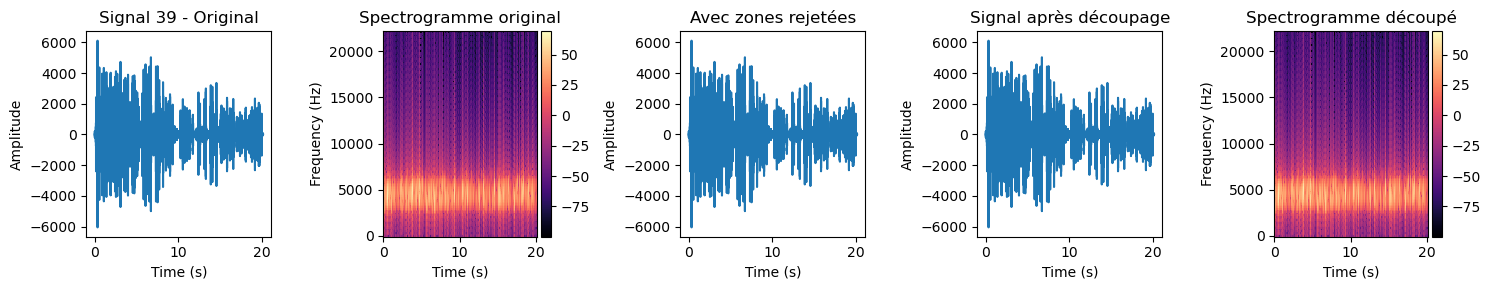

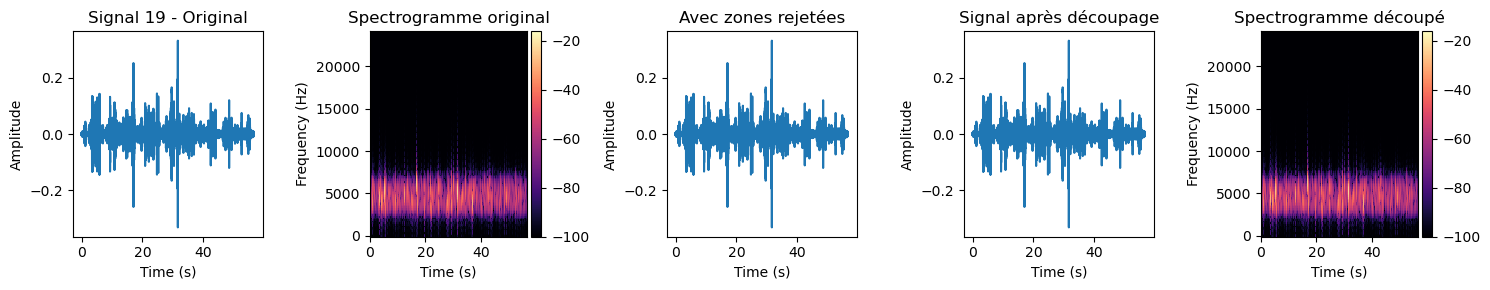

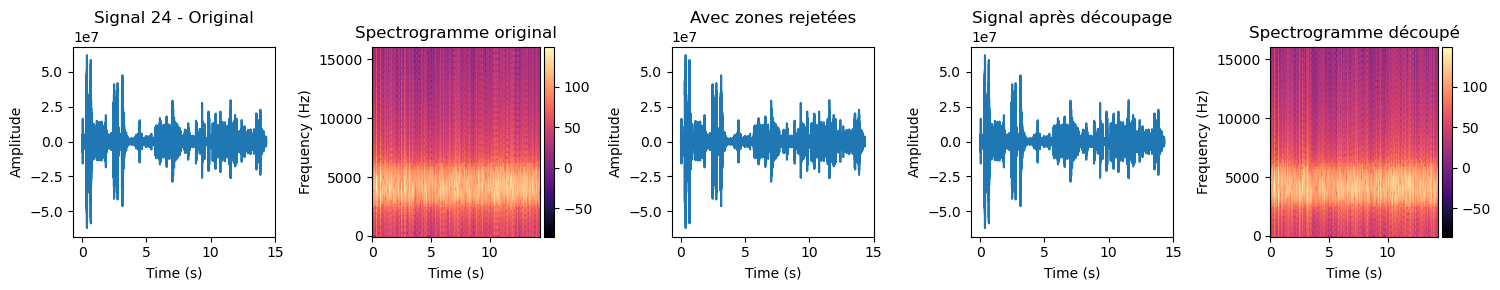

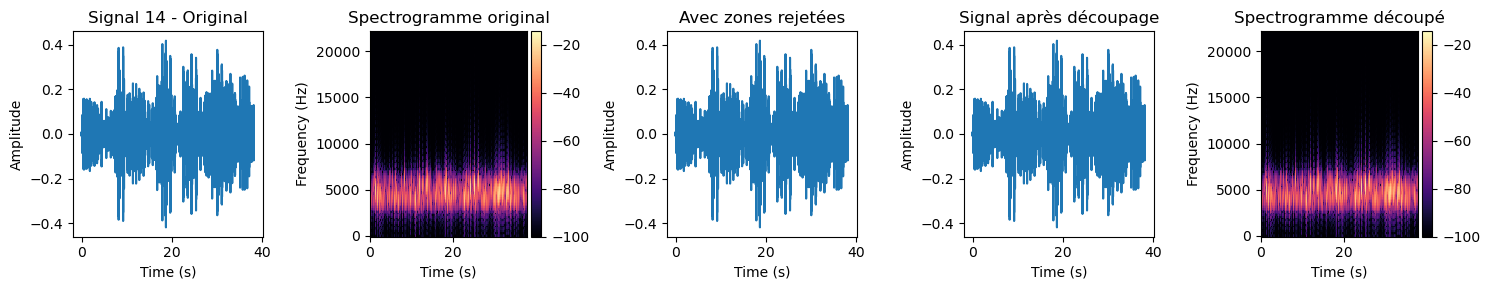

KeyboardInterrupt: 

In [8]:
# Visualisation des audiogrammes et des spectogrammes des signaux originaux et après découpage

import time  # au début de ton script

Nw = 64
No = 60

for i in range(len(Fs0)):
    fs = Fs0[i]
    pi_orig = filtré[indices_global[i]]
    plt.figure(figsize=(15, 3))

    # Signal original
    plt.subplot(1, 5, 1)
    t_signal = np.arange(len(pi_orig)) / fs
    plt.plot(t_signal, pi_orig)
    plt.title(f"Signal {indices_global[i]} - Original")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Spectrogramme original
    plt.subplot(1, 5, 2)
    f, t_spec, Sxx = my_spectrogram(pi_orig, Nw, No, fs)
    pmc=plt.pcolormesh(t_spec, f,10 * np.log10(np.abs(Sxx)**2 + 1e-10), shading='auto',cmap='magma')
    plt.colorbar(pmc, pad=0.02)
    plt.title("Spectrogramme original")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # Signal avec zones rejetées
    plt.subplot(1, 5, 3)
    plt.plot(t_signal, pi_orig)
    plt.title("Avec zones rejetées")
    for (x1, x2) in Clivage[i]:
        plt.axvline(x=x1 / fs, color='red', linestyle='--')
        plt.axvline(x=x2 / fs, color='green', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Signal après découpage
    pi_decoupe = Sign[i]
    plt.subplot(1, 5, 4)
    t_decoupe = np.arange(len(pi_decoupe)) / fs
    plt.plot(t_decoupe, pi_decoupe)
    plt.title("Signal après découpage")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Spectrogramme découpé
    plt.subplot(1, 5, 5)
    f2, t2, Sxx2 = my_spectrogram(pi_decoupe, Nw, No, fs)
    pcm=plt.pcolormesh(t2, f2, 10 * np.log10(np.abs(Sxx2)**2 + 1e-10), shading='auto',cmap='magma')
    plt.colorbar(pcm, pad=0.02)
    plt.title("Spectrogramme découpé")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()

    # 👇 Affiche la figure et laisse le script continuer après 1 seconde
    plt.show()
    plt.pause(1)  # attend 1 seconde avant de passer à la suivante
    # ne pas fermer la figure pour garder toutes ouvertes

In [11]:
# Redimensionne la taille de toutes les signaux pour la PCA

distance=[]
n1=0
for i in range(len(Fs)):
    pi=Sign[i] # prend le signal
    seuil=0.1*np.max(pi) # détermine le seuil 
    N=len(pi) # taille du signal
    while n1<N and pi[n1]<=seuil:  # moment où on dépasse le seuil
        n1+=1
    distance.append(n1)
    n1=0

# on détermine la taille minimale du signal court
min=len(Sign[0])
for i in range(len(Fs)):
    if len(Sign[i])<min:
        min=len(Sign[i])

# on crée des signaux modifiés avec la même taille
court=[]
for i in range(len(Fs)):
    pi=Sign[i]
    n1=distance[i]
    c=pi[n1:min+n1] # prend la taille du signal
    if len(c)<min:
        c=pi[0:min] # si plus petit on prend le minimum
    court.append(c)

In [14]:
# extraire la partie positive d'un signal
def positif2(x):
    p=np.zeros(len(x))
    for i in range(len(x)):
        if x[i] >= 0:
            p[i]=x[i]
    return p

In [15]:
# Fonction pour sélectionner des bandes d'énergies contenant des fréquences d'intérêt et pour déterminer la fréquence fondamentale du signal

def relative_energy_2(x, Nb, Fs, fmin, fmax):
    """
    Calcule l'énergie relative dans Nb bandes entre fmin et fmax Hz.
    
    Paramètres :
        x : signal temporel
        Nb : nombre de bandes de fréquence
        Fs : fréquence d'échantillonnage (Hz)
        fmin, fmax : bornes de la bande d'intérêt (Hz)
    Retour :
        E : énergie relative dans chaque bande (somme = 1)
    """
    Bornes=[]
    N = len(x) # longuer du signal
    X = np.fft.fft(x) # donne le spectre fréquentiel
    f = np.fft.fftfreq(N, d=1/Fs) # vecteur des fréquences associé à X
    
    # On ne garde que les fréquences positives entre fmin et fmax
    mask = (f >= fmin) & (f <= fmax)
    f_pos = f[mask]
    X_pos = X[mask]

    # Bornes des sous-bandes
    edges = np.linspace(fmin, fmax, Nb + 1) # bornes des bandes
    E = np.zeros(Nb) # energie relative de chaque bande
    
    # Énergie totale dans [fmin, fmax]
    total_energy = np.sum(np.abs(X_pos)**2) # calcul energie total
        # Fréquence fondamentale
    X_pos = X[f > 0]
    f_pos = f[f > 0]
    idx = np.argmax(np.abs(X_pos))
    f0 = f_pos[idx]
    # Énergie dans chaque sous-bande
    for i in range(Nb):
        f_low, f_high = edges[i], edges[i+1]
        band_mask = (f_pos >= f_low) & (f_pos < f_high)
        E[i] = np.sum(np.abs(X_pos[band_mask])**2) # prend la séquence entre deux bornes
        Bornes.append((f_low,f_high))
    # Normalisation (énergie relative)
    E /= total_energy 
    
    return E,Bornes,f0

# Calcul des métriques d'intérêt pour la PCA 

def compute_features(X): # renvoie le tableaux avec signaux en colonne et les features en lignes
    N,M=np.shape(X) # les signaux en colonnes(N) et les lignes avec chaque point(M)
    Y=np.zeros((7,M)) # 8 features en lignes et M colonnes
    for i in range(M): # on fait signal par signal
        Y[0,i]=np.mean(positif2(X[:,i])) # on rempli la première ligne pour signal i avec la moyenne du signal i 
        #Y[1,i]=np.var(X[:,i]) # variance
        #Y[2,i]=np.sqrt(np.sum(X[:,i])**2) # ecart type
        E,Bornes,f0=relative_energy_2(X[:,i],5,Fs0[i],3000,5000) # calcul de l'énergie 4000-5000, 3800-4600 E1-E5
        Y[1,i]=f0
        Y[2:7,i]=E # energie les trois dernière valeur
    return Y,Bornes

# Réalisation de la PCA

def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M)) 
    for d in range(D): # pour chaque feature
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:]) # normalise selon la features
    U,S,Vt=np.linalg.svd(X_) 
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

# Affichage PCA 

import numpy as np
import matplotlib.pyplot as plt
def plot_correlation_circle(U,feature_names,var_exp):
    D,D=np.shape(U)
    figure, axes = plt.subplots()
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')   
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()


[(np.float64(3000.0), np.float64(3400.0)), (np.float64(3400.0), np.float64(3800.0)), (np.float64(3800.0), np.float64(4200.0)), (np.float64(4200.0), np.float64(4600.0)), (np.float64(4600.0), np.float64(5000.0))]


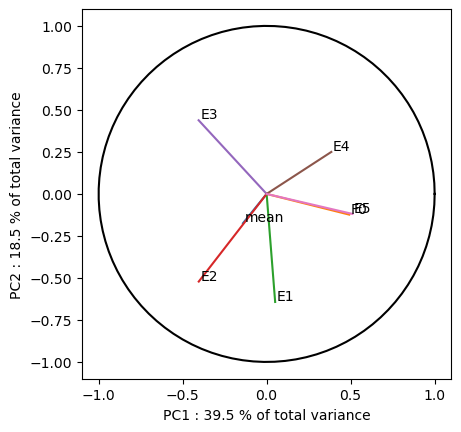

In [16]:
# Afficher le PCA
Y = np.column_stack(court) # les signaux en colonnes et les lignes avec chaque point
X,Bornes=compute_features(Y) # renvoie le tableaux avec signaux en colonne et les features en lignes
print(Bornes)
D,M=np.shape(X)
U,S_,var_exp=my_pca(X) # analyse en composante principale
feature_names = [
 'mean',
 'F0',
 'E1','E2','E3','E4','E5']

plot_correlation_circle(U,feature_names,var_exp)

In [17]:
# Visualisation de l'importance de chaque métrique
score=np.sqrt(U[:,0]**2+U[:,1]**2) 
ind = np.argsort(score)
ind=ind[::-1]

for d in range(D):
    print("Feature ", feature_names[ind[d]], " : ",score[ind[d]])

Feature  E2  :  0.6597296362581574
Feature  E1  :  0.6450644475496969
Feature  E3  :  0.596725449840275
Feature  E5  :  0.5242609681914788
Feature  F0  :  0.5068593919176555
Feature  E4  :  0.4589936647019281
Feature  mean  :  0.2239111718568261


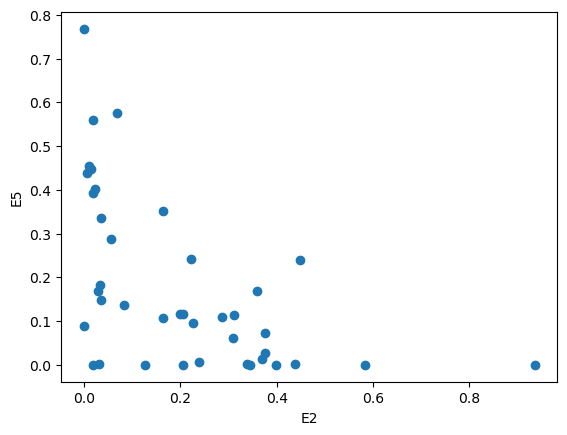

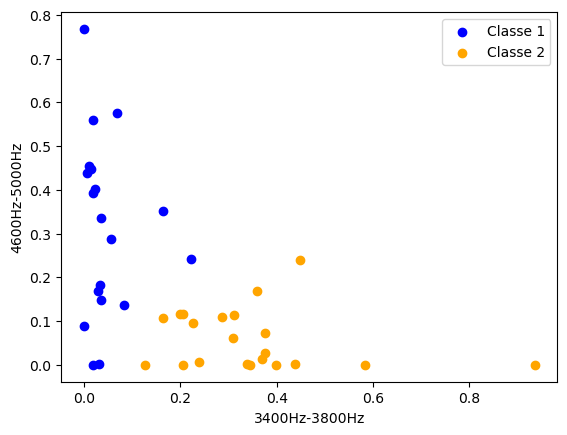

In [18]:
# Création de deux groupes selon E2 et E5
P=X[[3,6],:]
plt.scatter(X[3,:], X[6,:])
plt.xlabel('E2')
plt.ylabel('E5')
plt.show()
from sklearn.cluster import KMeans

P_t = P.T  # maintenant shape = (nombre_signaux, nombre_features)

# Créer le modèle KMeans avec 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Appliquer le clustering
kmeans.fit(P_t)

# Récupérer les labels des clusters
labels = kmeans.labels_

import numpy as np
import matplotlib.pyplot as plt

plt.scatter(X[3, labels==0], X[6, labels==0], color='blue', label='Classe 1')
plt.scatter(X[3, labels==1], X[6, labels==1], color='orange', label='Classe 2')

plt.xlabel('3400Hz-3800Hz')
plt.ylabel('4600Hz-5000Hz')
plt.legend()  # Affiche la légende
plt.show()

In [ ]:
# création d'un fichier npy avec les trois features en lignes et les signaux en ordonnée

import numpy as np

# Supposons que tu as trois listes de features
feature1 = X[3,:]  # ex : E2
feature2 = X[6,:]   # ex : E5
# ex : durée ou énergie

# ------------------------------
# 1. Combiner les listes en une matrice (nb_signaux x nb_features)
# ------------------------------
# np.column_stack aligne les listes en colonnes
X = np.column_stack((feature1, feature2))

print("Matrice finale :")
print(X)
# Résultat : 4 lignes (signaux) x 3 colonnes (features)

# ------------------------------
# 2. Sauvegarder en .npy
# ------------------------------
np.save("ARIA/cours/signal/projet/signal/signals_features.npy", X)
print("Fichier 'signals_features.npy' créé avec succès !")

In [ ]:
# lecture et kmeans du npy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------
# 1. Charger les données depuis le fichier .npy
# ------------------------------
# Supposons que ton fichier s'appelle 'signals_features.npy'
# Chaque ligne = un signal, chaque colonne = une feature
X = np.load('ARIA/cours/signal/projet/signal/signals_features.npy')

print(f"Shape des données : {X.shape}")  # devrait être (nb_signaux, nb_features)

# ------------------------------
# 2. Appliquer K-Means
# ------------------------------
n_clusters = 3  # nombre de clusters souhaité
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# ------------------------------
# 3. Visualisation 3D (si 3 features)
# ------------------------------
if X.shape[1] == 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap='viridis', s=50)
    ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=200, marker='X')  # centres

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('K-Means Clustering des Signaux')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

# ------------------------------
# 4. Si plus ou moins de 3 features
# ------------------------------
else:
    print("Les données n'ont pas 3 features : visualisation 2D ou PCA recommandée.")